In [52]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [53]:
import tarfile
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
from PIL import Image
import seaborn as sns
from pathlib import Path

In [54]:
base_path = Path("../data_caltech101/caltech-101")
tar_gz_file = base_path / "101_ObjectCategories.tar.gz"
annotations_tar = base_path / "Annotations.tar"

if tar_gz_file.exists():
    with tarfile.open(tar_gz_file, "r:gz") as tar:
        tar.extractall(base_path)
else:
    print("101_ObjectCategories.tar.gz")

if annotations_tar.exists():
    with tarfile.open(annotations_tar, "r") as tar:
        tar.extractall(base_path)
    print("Annotations.tar extrait")

C:\Users\aurel\AppData\Local\Temp\ipykernel_11724\3902903197.py:7: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(base_path)
C:\Users\aurel\AppData\Local\Temp\ipykernel_11724\3902903197.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(base_path)
C:\Users\aurel\AppData\Local\Temp\ipykernel_11724\3902903197.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(base_path)


Annotations.tar extrait


# 2. Téléchargement et exploration des données

## 2.1 Téléchargement et extraction du dataset

In [55]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 2.2 Structure du dataset

In [56]:
dataset_path = Path("../data_caltech101/caltech-101/101_ObjectCategories")

if dataset_path.exists():
    all_items = sorted([item for item in dataset_path.iterdir()])
    
    folders = [item for item in all_items if item.is_dir()]
    files = [item for item in all_items if item.is_file()]
    
    print(f"\nNombre dossiers: {len(folders)}")
    
    if files:
        print("\nFichiers à la racine:")
        for f in files:
            print(f"  - {f.name}")
    
    print(f"\nPremiers 10 dossiers (classes potentielles):")
    for folder in folders[:10]:
        images = list(folder.glob("*.jpg")) + list(folder.glob("*.png"))
        print(f"  - {folder.name}: {len(images)} images")
else:
    print("Le dataset n'existe pas. Assurez-vous qu'il a été téléchargé et extrait.")


Nombre dossiers: 102

Premiers 10 dossiers (classes potentielles):
  - accordion: 55 images
  - airplanes: 800 images
  - anchor: 42 images
  - ant: 42 images
  - BACKGROUND_Google: 467 images
  - barrel: 47 images
  - bass: 54 images
  - beaver: 46 images
  - binocular: 33 images
  - bonsai: 128 images


In [57]:
classes = [item.name for item in dataset_path.iterdir() if item.is_dir() and item.name != "BACKGROUND_Google"]

print(f"\nNombre de classes réelles: {len(classes)}")
print("\nPourquoi retirer BACKGROUND_Google?")
print("  images de fond")
print("  images ne représentent pas une catégorie d'objets cohérente")
print("  utilisées comme images 'négatives' dans certaines configurations")


Nombre de classes réelles: 101

Pourquoi retirer BACKGROUND_Google?
  images de fond
  images ne représentent pas une catégorie d'objets cohérente
  utilisées comme images 'négatives' dans certaines configurations


In [58]:
examples = [
    ("accordion", "Instrument de musique à vent et à clavier"),
    ("airplanes", "Avions - véhicules volants"),
    ("camera", "Appareils photo"),
    ("elephant", "Éléphants - mammifères terrestres"),
    ("soccer_ball", "Ballons de football")
]

for i, (class_name, description) in enumerate(examples, 1):
    class_path = dataset_path / class_name
    if class_path.exists():
        num_images = len(list(class_path.glob("*.jpg"))) + len(list(class_path.glob("*.png")))
        print(f"{i}. {class_name}: {description}")
        print(f"   Nombre d'images: {num_images}")
    else:
        print(f"{i}. {class_name}: (non trouvée dans le dataset)")

1. accordion: Instrument de musique à vent et à clavier
   Nombre d'images: 55
2. airplanes: Avions - véhicules volants
   Nombre d'images: 800
3. camera: Appareils photo
   Nombre d'images: 50
4. elephant: Éléphants - mammifères terrestres
   Nombre d'images: 64
5. soccer_ball: Ballons de football
   Nombre d'images: 64


## 2.3 Distribution des classes

In [59]:
class_distribution = {}

for class_folder in dataset_path.iterdir():
    if class_folder.is_dir() and class_folder.name != "BACKGROUND_Google":
        images = list(class_folder.glob("*.jpg")) + list(class_folder.glob("*.png"))
        class_distribution[class_folder.name] = len(images)

# Trier par nombre d'images
sorted_distribution = dict(sorted(class_distribution.items(), key=lambda x: x[1]))

print(f"Nombre total d'images: {sum(class_distribution.values())}")
print(f"Moyenne d'images par classe: {np.mean(list(class_distribution.values())):.2f}")
print(f"Médiane: {np.median(list(class_distribution.values())):.2f}")
print(f"Écart-type: {np.std(list(class_distribution.values())):.2f}")

Nombre total d'images: 8677
Moyenne d'images par classe: 85.91
Médiane: 59.00
Écart-type: 117.75
Moyenne d'images par classe: 85.91
Médiane: 59.00
Écart-type: 117.75


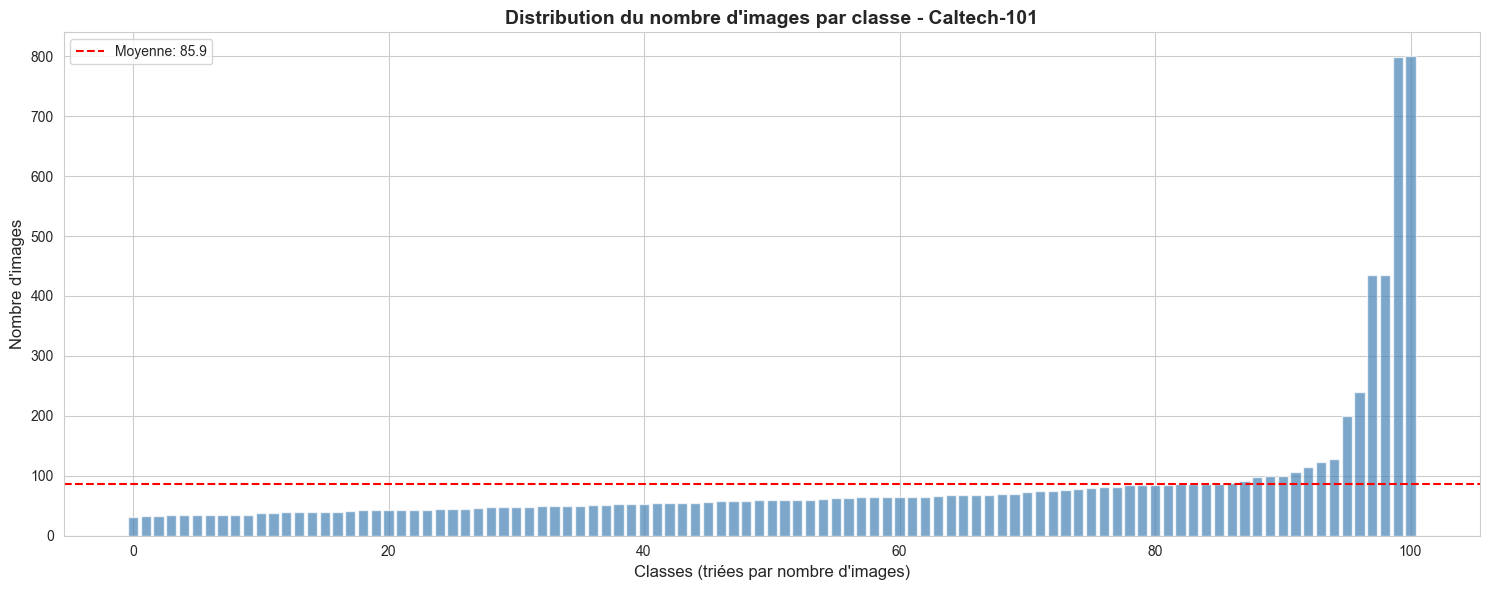

In [60]:
plt.figure(figsize=(15, 6))
plt.bar(range(len(sorted_distribution)), sorted_distribution.values(), color='steelblue', alpha=0.7)
plt.xlabel('Classes (triées par nombre d\'images)', fontsize=12)
plt.ylabel('Nombre d\'images', fontsize=12)
plt.title('Distribution du nombre d\'images par classe - Caltech-101', fontsize=14, fontweight='bold')
plt.axhline(y=np.mean(list(class_distribution.values())), color='red', linestyle='--', 
            label=f'Moyenne: {np.mean(list(class_distribution.values())):.1f}')
plt.legend()
plt.tight_layout()
plt.show()

In [61]:
print("\n5 classes les plus SOUS-représentées:")
for i, (class_name, count) in enumerate(list(sorted_distribution.items())[:5], 1):
    print(f"{i}. {class_name}: {count} images")

print("\n5 classes les plus SUR-représentées:")
for i, (class_name, count) in enumerate(list(sorted_distribution.items())[-5:], 1):
    print(f"{i}. {class_name}: {count} images")

cv = (np.std(list(class_distribution.values())) / np.mean(list(class_distribution.values()))) * 100
print(f"\nCoefficient de variation: {cv:.2f}%")

if cv < 30:
    equilibre = "ÉQUILIBRÉ"
elif cv < 60:
    equilibre = "MODÉRÉMENT DÉSÉQUILIBRÉ"
else:
    equilibre = "TRÈS DÉSÉQUILIBRÉ"

print(f"DATASET {equilibre}")


5 classes les plus SOUS-représentées:
1. inline_skate: 31 images
2. metronome: 32 images
3. binocular: 33 images
4. garfield: 34 images
5. gerenuk: 34 images

5 classes les plus SUR-représentées:
1. watch: 239 images
2. Faces: 435 images
3. Faces_easy: 435 images
4. Motorbikes: 798 images
5. airplanes: 800 images

Coefficient de variation: 137.06%
DATASET TRÈS DÉSÉQUILIBRÉ


1. **Le dataset est-il équilibré?**
   - Le dataset Caltech-101 est désequilibre, le nombre d'images varie significativement entre les classes.

2. **Classes sous/sur-représentées:**
   - Les classes sous-représentées ont généralement moins de 50 images
   - Les classes sur-représentées peuvent avoir plus de 400 images
   (de 30 a 800)

3. **Influence sur l'entraînement:**
   - Biais du modèle: Le modèle aura tendance à mieux apprendre les classes sur-représentées
   - Risque de surapprentissage pour les classes avec peu d'exemples
   - L'accuracy globale peut être élevée même si le modèle échoue sur les petites classes
   - Solutions possibles: 
     - Pondération des classes (class weights)
     - Data augmentation ciblée pour les classes minoritaires
     - Utilisation de métriques balancées (F1-score, balanced accuracy)

## 2.4 Visualisation des données

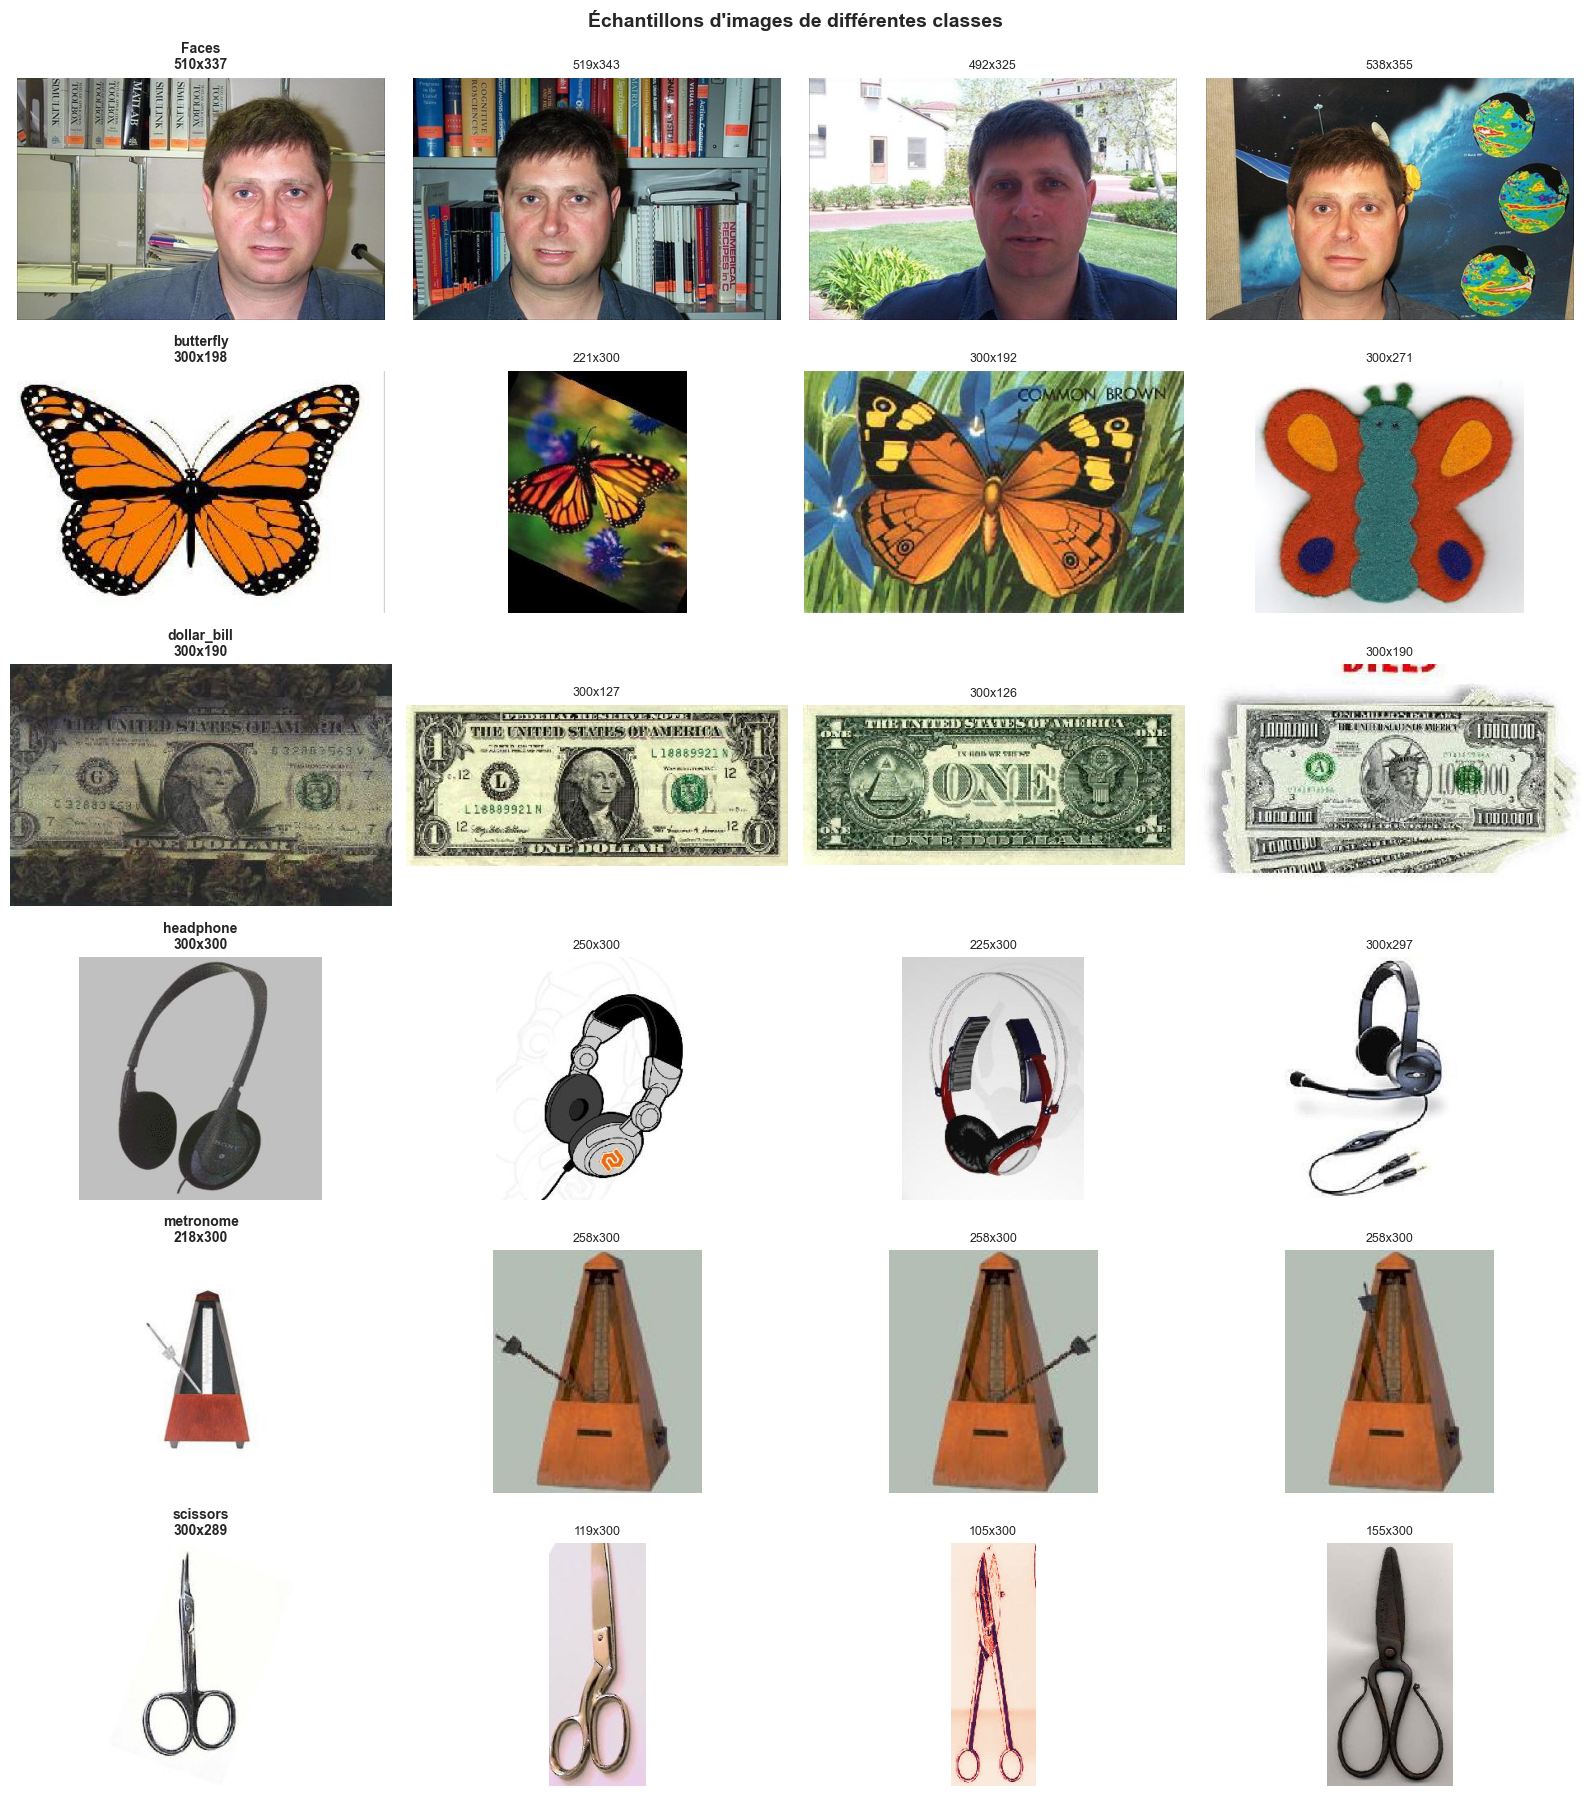

In [62]:
def visualize_samples(dataset_path, num_classes=6, images_per_class=4):
    all_classes = [c for c in sorted(class_distribution.keys())]
    step = len(all_classes) // num_classes
    selected_classes = [all_classes[i * step] for i in range(num_classes)]

    fig, axes = plt.subplots(
        num_classes, images_per_class, figsize=(16, 3 * num_classes)
    )

    image_sizes = []

    for i, class_name in enumerate(selected_classes):
        class_path = dataset_path / class_name
        images = list(class_path.glob("*.jpg"))[:images_per_class]

        for j, img_path in enumerate(images):
            img = Image.open(img_path)
            image_sizes.append(img.size)

            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            if j == 0:
                axes[i, j].set_title(
                    f"{class_name}\n{img.size[0]}x{img.size[1]}",
                    fontsize=10,
                    fontweight="bold",
                )
            else:
                axes[i, j].set_title(f"{img.size[0]}x{img.size[1]}", fontsize=9)

    plt.suptitle(
        "Échantillons d'images de différentes classes",
        fontsize=14,
        fontweight="bold",
        y=0.995,
    )
    plt.tight_layout()
    plt.show()

    return image_sizes

image_sizes = visualize_samples(dataset_path)

In [63]:
widths = [size[0] for size in image_sizes]
heights = [size[1] for size in image_sizes]

print(f"\nLargeur - Min: {min(widths)}, Max: {max(widths)}, Moyenne: {np.mean(widths):.1f}")
print(f"Hauteur - Min: {min(heights)}, Max: {max(heights)}, Moyenne: {np.mean(heights):.1f}")

unique_sizes = set(image_sizes)
print(f"\nNombre de tailles différentes: {len(unique_sizes)}")


Largeur - Min: 105, Max: 538, Moyenne: 296.9
Hauteur - Min: 126, Max: 355, Moyenne: 272.5

Nombre de tailles différentes: 21


Les tailles ne sont pas homogenes

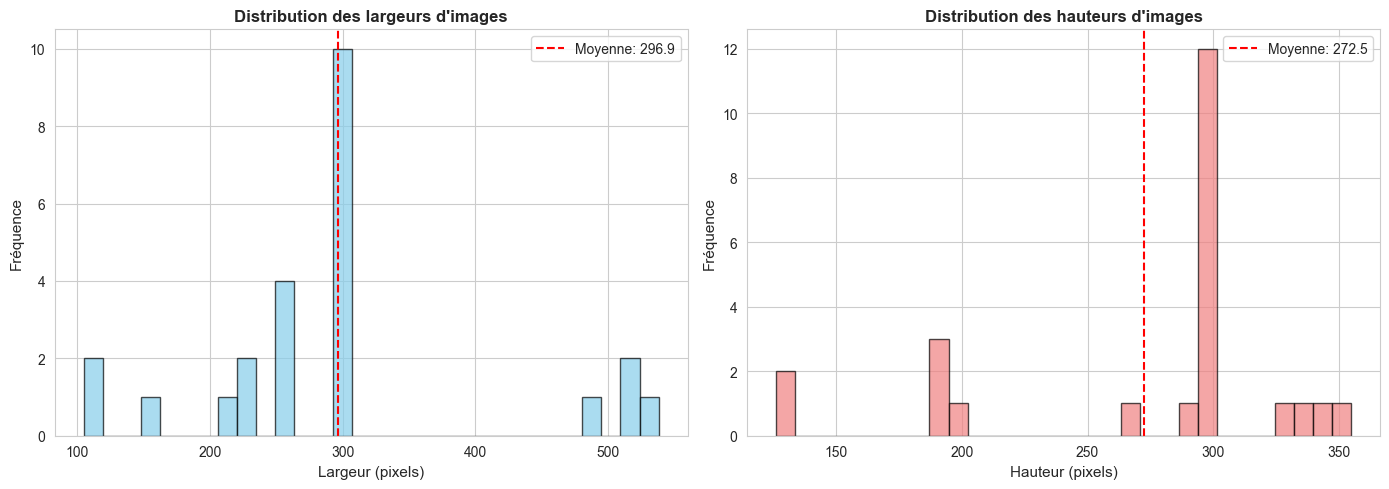

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(widths, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('Largeur (pixels)', fontsize=11)
ax1.set_ylabel('Fréquence', fontsize=11)
ax1.set_title('Distribution des largeurs d\'images', fontsize=12, fontweight='bold')
ax1.axvline(np.mean(widths), color='red', linestyle='--', label=f'Moyenne: {np.mean(widths):.1f}')
ax1.legend()

ax2.hist(heights, bins=30, color='lightcoral', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Hauteur (pixels)', fontsize=11)
ax2.set_ylabel('Fréquence', fontsize=11)
ax2.set_title('Distribution des hauteurs d\'images', fontsize=12, fontweight='bold')
ax2.axvline(np.mean(heights), color='red', linestyle='--', label=f'Moyenne: {np.mean(heights):.1f}')
ax2.legend()

plt.tight_layout()
plt.show()

**Réponses aux questions:**

1. **Les tailles d'images sont-elles homogènes?**
   - Non les images ont des tailles très variées.

2. **Types de variations visuelles observées:**
   - Contraste: Certaines images sont très contrastées, d'autres ont un faible contraste
   - Position de l'objet: Les objets peuvent être centrés, décentrés, ou occuper différentes portions de l'image
   - Échelle: Les objets peuvent être photographiés de près (gros plan) ou de loin
   - Orientation: Rotation et angles de vue variables
   - Fond: Fonds uniformes, complexes, ou naturels
   - Qualité: Résolution et netteté variables
   - Éclairage: Conditions d'éclairage différentes

# 3. Prétraitement et préparation du dataset

## 3.1 Choix de la résolution d'entrée

**Choix de résolution: 128x128 pixels**

**Justifications:**

**Avantages du 128x128:**
- **Bon compromis information/coût**: Préserve suffisamment de détails pour la plupart des objets
- **Coût computationnel raisonnable**: 
  - Taille mémoire modérée pour un batch
  - Temps d'entraînement acceptable sur GPU standard
- **Compatible avec architectures modernes**: Beaucoup de CNN pré-entraînés acceptent cette résolution
- **Supérieur à 64x64**: 64x64 entraînerait une perte significative de détails pour les objets complexes

**Comparaison:**
- **64x64**: 12,288 pixels → Trop de perte d'information pour des catégories fines
- **128x128**: 49,152 pixels → **CHOIX RETENU**
- **224x224**: 150,528 pixels → 3x plus coûteux, gain marginal pour ce dataset

**Analyse du coût computationnel:**
- Batch de 32 images en 128x128x3: ~6 MB de mémoire
- Entraînement environ 2-3x plus rapide que du 224x224
- Permet l'utilisation de batch sizes plus grands

In [65]:
IMG_SIZE = 128
BATCH_SIZE = 32
RANDOM_SEED = 42

print(f"Configuration retenue:")
print(f"  - Résolution: {IMG_SIZE}x{IMG_SIZE} pixels")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Nombre de canaux: 3 (RGB)")
print(f"  - Mémoire par image: {IMG_SIZE * IMG_SIZE * 3 * 4 / 1024:.2f} KB (float32)")
print(f"  - Mémoire par batch: {IMG_SIZE * IMG_SIZE * 3 * 4 * BATCH_SIZE / 1024 / 1024:.2f} MB")

Configuration retenue:
  - Résolution: 128x128 pixels
  - Batch size: 32
  - Nombre de canaux: 3 (RGB)
  - Mémoire par image: 192.00 KB (float32)
  - Mémoire par batch: 6.00 MB


## 3.2 Normalisation

**Méthode de normalisation adoptée: Normalisation par ImageNet**

**Approche:**
```python
mean = [0.485, 0.456, 0.406]  # Moyennes RGB d'ImageNet
std = [0.229, 0.224, 0.225]   # Écarts-types RGB d'ImageNet
```

**Motivations:**

1. **Transfer Learning**: Si on utilise des poids pré-entraînés sur ImageNet, cette normalisation est **obligatoire**

2. **Standardisation éprouvée**: Ces valeurs sont le standard dans la communauté

3. **Stabilité de l'entraînement**:
   - Ramène les valeurs autour de 0 avec variance 1
   - Facilite la convergence du gradient descent
   - Réduit les problèmes de vanishing/exploding gradients

4. **Alternative considérée** (si entraînement from scratch):
   - Calculer mean/std directement sur Caltech-101
   - Mais moins pertinent si on fait du transfer learning

**Transformation complète:**
1. Redimensionnement → 128x128
2. Conversion en tenseur → Valeurs [0, 1]
3. Normalisation → mean/std ImageNet

In [66]:
# Calcul optionnel: statistiques du dataset Caltech-101
# (pour comparaison avec ImageNet)

print("Calcul des statistiques du dataset Caltech-101...")
print("(Échantillon de 1000 images pour estimation rapide)\n")

sample_images = []
count = 0
max_samples = 1000

for class_folder in dataset_path.iterdir():
    if class_folder.is_dir() and class_folder.name != "BACKGROUND_Google":
        images = list(class_folder.glob("*.jpg"))[:10]
        for img_path in images:
            if count >= max_samples:
                break
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize((IMG_SIZE, IMG_SIZE))
                img_array = np.array(img) / 255.0
                sample_images.append(img_array)
                count += 1
            except:
                pass
        if count >= max_samples:
            break

sample_images = np.array(sample_images)

# Calculer mean et std par canal
caltech_mean = sample_images.mean(axis=(0, 1, 2))
caltech_std = sample_images.std(axis=(0, 1, 2))

print(f"Statistiques Caltech-101 (échantillon de {len(sample_images)} images):")
print(f"  Mean RGB: [{caltech_mean[0]:.3f}, {caltech_mean[1]:.3f}, {caltech_mean[2]:.3f}]")
print(f"  Std RGB:  [{caltech_std[0]:.3f}, {caltech_std[1]:.3f}, {caltech_std[2]:.3f}]")

print(f"\nStatistiques ImageNet (standard):")
print(f"  Mean RGB: [0.485, 0.456, 0.406]")
print(f"  Std RGB:  [0.229, 0.224, 0.225]")

print("\n→ Nous utiliserons les statistiques ImageNet pour le transfer learning")

Calcul des statistiques du dataset Caltech-101...
(Échantillon de 1000 images pour estimation rapide)

Statistiques Caltech-101 (échantillon de 1000 images):
  Mean RGB: [0.547, 0.519, 0.489]
  Std RGB:  [0.327, 0.324, 0.334]

Statistiques ImageNet (standard):
  Mean RGB: [0.485, 0.456, 0.406]
  Std RGB:  [0.229, 0.224, 0.225]

→ Nous utiliserons les statistiques ImageNet pour le transfer learning
Statistiques Caltech-101 (échantillon de 1000 images):
  Mean RGB: [0.547, 0.519, 0.489]
  Std RGB:  [0.327, 0.324, 0.334]

Statistiques ImageNet (standard):
  Mean RGB: [0.485, 0.456, 0.406]
  Std RGB:  [0.229, 0.224, 0.225]

→ Nous utiliserons les statistiques ImageNet pour le transfer learning


## 3.3 Split train/validation/test

**Configuration des splits:**

- **Train**: 70% (entraînement du modèle)
- **Validation**: 15% (tuning des hyperparamètres, early stopping)
- **Test**: 15% (évaluation finale, jamais vu pendant l'entraînement)

**Justifications:**

1. **Pourcentages choisis:**
   - **70% train**: Suffisant pour l'apprentissage malgré le dataset limité
   - **15% validation**: Assez d'exemples pour estimer la performance de généralisation
   - **15% test**: Set test indépendant pour évaluation finale non biaisée
   
2. **Stratification NÉCESSAIRE**: **OUI, absolument**
   - Le dataset est déséquilibré (vu en section 1.3)
   - Sans stratification, certaines classes minoritaires pourraient être absentes du validation/test
   - La stratification garantit que chaque split contient des exemples de **toutes** les classes
   - Maintient la distribution des classes dans chaque split

3. **Vérification des duplicatas:**
   - Utilisation de sets disjoints basés sur les indices
   - Vérification par assertion: `len(train ∩ val ∩ test) = 0`
   - Tracking des chemins de fichiers pour éviter les doublons

In [67]:
from sklearn.model_selection import train_test_split
import json

# Collecter tous les chemins d'images et leurs labels
all_image_paths = []
all_labels = []
class_to_idx = {}

print("Collecte des images...")
idx = 0
for class_folder in sorted(dataset_path.iterdir()):
    if class_folder.is_dir() and class_folder.name != "BACKGROUND_Google":
        class_to_idx[class_folder.name] = idx
        images = list(class_folder.glob("*.jpg"))
        for img_path in images:
            all_image_paths.append(str(img_path))
            all_labels.append(idx)
        idx += 1

print(f"Total d'images collectées: {len(all_image_paths)}")
print(f"Nombre de classes: {len(class_to_idx)}")

# Convertir en arrays numpy
all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

Collecte des images...
Total d'images collectées: 8677
Nombre de classes: 101


In [68]:
# Split stratifié train/temp (train 70%, temp 30%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_image_paths, 
    all_labels,
    test_size=0.30,
    stratify=all_labels,
    random_state=RANDOM_SEED
)

# Split stratifié temp → validation/test (15% / 15% du total)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths,
    temp_labels,
    test_size=0.50,  # 50% de 30% = 15% du total
    stratify=temp_labels,
    random_state=RANDOM_SEED
)

print("SPLIT DU DATASET")
print("="*70)
print(f"Train:      {len(train_paths)} images ({len(train_paths)/len(all_image_paths)*100:.1f}%)")
print(f"Validation: {len(val_paths)} images ({len(val_paths)/len(all_image_paths)*100:.1f}%)")
print(f"Test:       {len(test_paths)} images ({len(test_paths)/len(all_image_paths)*100:.1f}%)")
print(f"Total:      {len(all_image_paths)} images")

SPLIT DU DATASET
Train:      6073 images (70.0%)
Validation: 1302 images (15.0%)
Test:       1302 images (15.0%)
Total:      8677 images


In [69]:
# Vérification 1: Pas de duplicatas entre les sets
train_set = set(train_paths)
val_set = set(val_paths)
test_set = set(test_paths)

intersection_train_val = train_set & val_set
intersection_train_test = train_set & test_set
intersection_val_test = val_set & test_set

print("\nVÉRIFICATION DES DUPLICATAS")
print("="*70)
print(f"Intersection train/val:  {len(intersection_train_val)} images")
print(f"Intersection train/test: {len(intersection_train_test)} images")
print(f"Intersection val/test:   {len(intersection_val_test)} images")

if len(intersection_train_val) == 0 and len(intersection_train_test) == 0 and len(intersection_val_test) == 0:
    print("✓ AUCUN DUPLICATA détecté entre les splits")
else:
    print("✗ ATTENTION: Des duplicatas ont été détectés!")


VÉRIFICATION DES DUPLICATAS
Intersection train/val:  0 images
Intersection train/test: 0 images
Intersection val/test:   0 images
✓ AUCUN DUPLICATA détecté entre les splits


In [70]:
# Vérification 1: Pas de duplicatas entre les sets
train_set = set(train_paths)
val_set = set(val_paths)
test_set = set(test_paths)

intersection_train_val = train_set & val_set
intersection_train_test = train_set & test_set
intersection_val_test = val_set & test_set

print("\nVÉRIFICATION DES DUPLICATAS")
print("="*70)
print(f"Intersection train/val:  {len(intersection_train_val)} images")
print(f"Intersection train/test: {len(intersection_train_test)} images")
print(f"Intersection val/test:   {len(intersection_val_test)} images")

if len(intersection_train_val) == 0 and len(intersection_train_test) == 0 and len(intersection_val_test) == 0:
    print("✓ AUCUN DUPLICATA détecté entre les splits")
else:
    print("✗ ATTENTION: Des duplicatas ont été détectés!")


VÉRIFICATION DES DUPLICATAS
Intersection train/val:  0 images
Intersection train/test: 0 images
Intersection val/test:   0 images
✓ AUCUN DUPLICATA détecté entre les splits


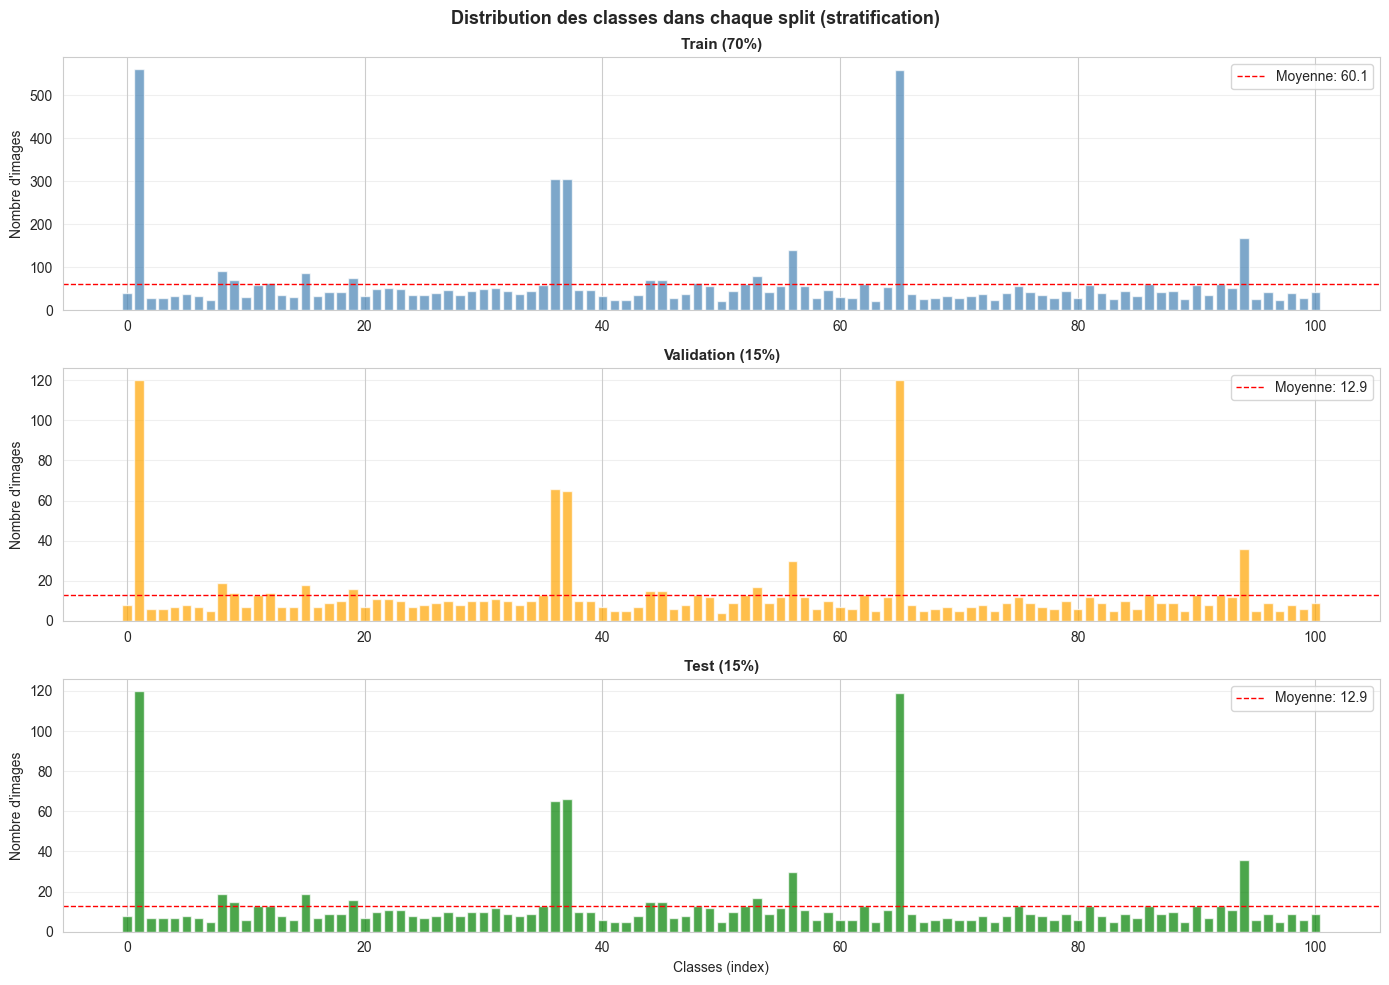

In [71]:
# Visualisation de la distribution
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

splits = [
    (train_labels, "Train (70%)", "steelblue"),
    (val_labels, "Validation (15%)", "orange"),
    (test_labels, "Test (15%)", "green")
]

for idx, (labels, title, color) in enumerate(splits):
    counter = Counter(labels)
    sorted_counts = [counter[i] for i in sorted(counter.keys())]
    
    axes[idx].bar(range(len(sorted_counts)), sorted_counts, color=color, alpha=0.7)
    axes[idx].set_ylabel('Nombre d\'images', fontsize=10)
    axes[idx].set_title(title, fontsize=11, fontweight='bold')
    axes[idx].axhline(y=np.mean(sorted_counts), color='red', linestyle='--', 
                     linewidth=1, label=f'Moyenne: {np.mean(sorted_counts):.1f}')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)

axes[2].set_xlabel('Classes (index)', fontsize=10)
plt.suptitle('Distribution des classes dans chaque split (stratification)', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

In [72]:
# Sauvegarder les splits pour utilisation ultérieure
splits_info = {
    'train': train_paths.tolist(),
    'validation': val_paths.tolist(),
    'test': test_paths.tolist(),
    'class_to_idx': class_to_idx,
    'config': {
        'img_size': IMG_SIZE,
        'train_ratio': 0.70,
        'val_ratio': 0.15,
        'test_ratio': 0.15,
        'random_seed': RANDOM_SEED,
        'total_images': len(all_image_paths),
        'num_classes': len(class_to_idx)
    }
}

# Sauvegarder dans un fichier JSON
output_path = Path("./splits_info.json")
with open(output_path, 'w') as f:
    json.dump(splits_info, f, indent=2)

print(f"\n✓ Informations des splits sauvegardées dans: {output_path}")
print(f"  Vous pouvez réutiliser ces splits pour garantir la reproductibilité")


✓ Informations des splits sauvegardées dans: splits_info.json
  Vous pouvez réutiliser ces splits pour garantir la reproductibilité
